# ARMA - breakdown

In [62]:
import sys
import pandas as pd
import numpy as np
from numpy import log
from pandas import Series

from scipy import stats

import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AR
#from pandas.core import datetools
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.ar_model import AR

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams

plt.rcParams['figure.figsize']=(20,10)
plt.style.use('ggplot')

import seaborn as sns

from pandas.plotting import lag_plot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


## MA process

A moving average process is actually based on white noise. It is defined as a weighted average of the previous white noise values.

a pure Moving Average (MA only) model is one where $Y_t$ depends only on the lagged forecast errors.

MA process
A moving average process is actually based on this white noise. It is defined as a weighted average of the previous white noise values.

$$ \Large X_t = \mu + \epsilon_t + \sum_{i=1}^{q}{\theta_i \epsilon_{t-i}} $$

Where 
- θ are the parameters of the process and 
- q is the order of the process. 

With order we mean how many time steps q we should include in the weighted average.


## White noise

Let’s look at a very simple stochastic process called white noise. White noise can be drawn from many kinds of distributions. Here we draw from an univariate Gaussian.

$$ \Large \epsilon \sim N(0, 1) $$

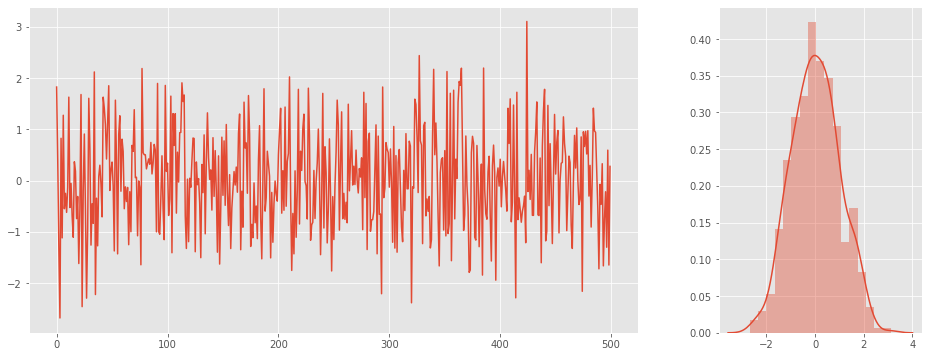

In [4]:
n = 500
fig, ax = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios':[3, 1]})

eps = np.random.normal(size=n)

ax[0].plot(eps)
sns.distplot(eps, ax=ax[1]);

- This process is completely random. 

- normal distribution with zero mean and unit variance. 

- White noise is actually something we want to see on the residuals after we’ve defined a model. 

- If the residuals follow a white noise pattern, we can be certain that we’ve declared all the possible variance.

In [5]:
def lag_view(x, order):
    """
    For every value X_i create a row that lags k values: [X_i-1, X_i-2, ... X_i-k]
    """
    y = x.copy()
    
    # Create features by shifting the window of `order` size by one step.
    # This results in a 2D array [[t1, t2, t3], [t2, t3, t4], ... [t_k-2, t_k-1, t_k]]
    x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])
    
    # Reverse the array as we started at the end and remove duplicates.
    
    # Note that we truncate the features [order -1:] and the labels [order]
    # This is the shifting of the features with one time step compared to the labels
    #x = np.stack(x)[::-1][order - 1: -1]
    x = np.stack(x)[::-1][order - 1: ]
    y = y[order:]

    return x, y

In [6]:
lag_view(np.arange(10), 3)

(array([[0, 1, 2],
        [1, 2, 3],
        [2, 3, 4],
        [3, 4, 5],
        [4, 5, 6],
        [5, 6, 7],
        [6, 7, 8],
        [7, 8, 9]]), array([3, 4, 5, 6, 7, 8, 9]))

In [7]:
y = np.arange(10)

In [8]:
y.shape[0]

10

In [9]:
order = 3

for i in range(y.shape[0]):
    print(y[-(i + order):][:order])

[7 8 9]
[6 7 8]
[5 6 7]
[4 5 6]
[3 4 5]
[2 3 4]
[1 2 3]
[0 1 2]
[0 1 2]
[0 1 2]


In [10]:
# when i = 0
i = 0
y[-(i + order):][:order]

array([7, 8, 9])

In [11]:
# when i = 1
i = 1
y[-(i + order):][:order]

array([6, 7, 8])

In [12]:
# when i = 2
i = 2
y[-(i + order):][:order]

array([5, 6, 7])

In [13]:
# Explanation is in above lines
np.array([y[-(i + order):][:order] for i in range(y.shape[0])])

array([[7, 8, 9],
       [6, 7, 8],
       [5, 6, 7],
       [4, 5, 6],
       [3, 4, 5],
       [2, 3, 4],
       [1, 2, 3],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [14]:
x = np.array([y[-(i + order):][:order] for i in range(y.shape[0])])

In [15]:
np.stack(x)

array([[7, 8, 9],
       [6, 7, 8],
       [5, 6, 7],
       [4, 5, 6],
       [3, 4, 5],
       [2, 3, 4],
       [1, 2, 3],
       [0, 1, 2],
       [0, 1, 2],
       [0, 1, 2]])

In [16]:
np.stack(x)[::-1]

array([[0, 1, 2],
       [0, 1, 2],
       [0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])

In [17]:
np.stack(x)[::-1][order - 1: ]

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])

In [18]:
lag_view(np.arange(10), 3)[0]


array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4],
       [3, 4, 5],
       [4, 5, 6],
       [5, 6, 7],
       [6, 7, 8],
       [7, 8, 9]])

## Define MA process

In [1]:
eps[:10]

NameError: name 'eps' is not defined

In [20]:
def ma_process(eps, theta):
    """
    Creates an MA(q) process with a zero mean (mean not included in implementation).
    :param eps: (array) White noise signal.
    :param theta: (array/ list) Parameters of the process.
    """
    # reverse the order of theta as Xt, Xt-1, Xt-k in an array is Xt-k, Xt-1, Xt.
    theta = np.array([1] + list(theta))[::-1][:, None]
    
    eps_q, _ = lag_view(eps, len(theta))
    
    return eps_q @ theta

In [21]:
# explanation
i = 0
np.random.uniform(0, 1, size= i + 1)

array([0.24312966])

In [22]:
i = 5
np.random.uniform(0, 1, size=i + 1)

array([0.75396083, 0.44652948, 0.99870237, 0.25331997, 0.53485866,
       0.42396604])

In [23]:
i = 10
np.random.uniform(0, 1, size=i + 1)

array([0.61876361, 0.81081496, 0.40637268, 0.96836195, 0.47534599,
       0.64587155, 0.86538   , 0.6803132 , 0.06670497, 0.6234052 ,
       0.27167899])

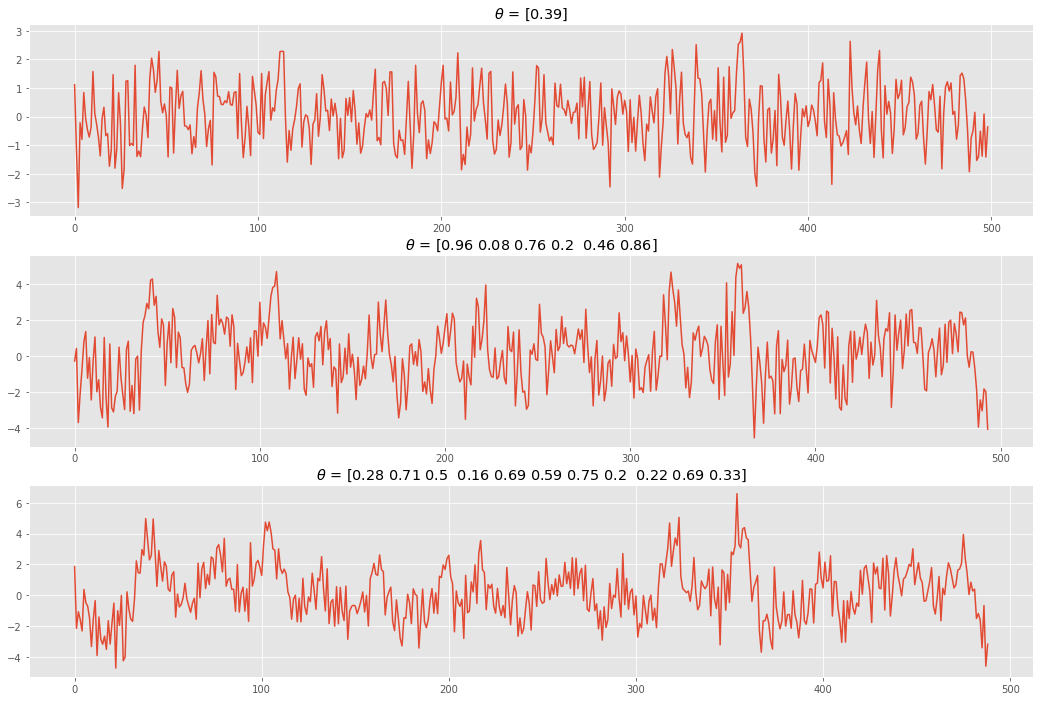

In [24]:
fig = plt.figure(figsize=(18, 4 * 3))
a = 310

for i in range(0, 11, 5):
    a += 1
    
    theta = np.random.uniform(0, 1, size=i + 1)
    
    plt.subplot(a)
    plt.title(f'$\\theta$ = {theta.round(2)}')
    plt.plot(ma_process(eps, theta))


In the plots above can be seen that when the order of MA(q) increases, the values are longer correlated with previous values. Actually, because the process is a weighted average of the ϵ values until lag q
, the correlation drops after this lag. 

Based of this property we can make an educated guess on about order of an MA(q) process. 

This is great because it is very hard to infer the order by looking at the plots directly.

## Autocorrelation
When a value $X_t$ is correlated with a previous value $X_{t−k}$ , this is called __autocorrelation__. The autocorrelation function is defined as:

$$ \Large ACF(X_t, X_{t-k}) = \frac{E[(X_t - \mu_t)(X_{t-k} - \mu_{t-k})]}{\sigma_t \sigma_{t-k}}$$ 

In [39]:
def pearson_correlation(x, y):
    return np.mean((x - x.mean()) * (y - y.mean())) / (x.std() * y.std())

In [40]:
def acf(x, lag=40):
    """
    Determine autocorrelation factors.
    :param x: (array) Time series.
    :param lag: (int) Number of lags.
    """
    return np.array([1] + [pearson_correlation(x[:-i], x[i:]) for i in range(1, lag)])

In [41]:
lag = 40

# Create an ma(1) and an ma(2) process.
ma_1 = ma_process(eps, [1])
ma_2 = ma_process(eps, [0.2, -0.3, 0.8])

Above we have created an MA(1) and an MA(2) process with different weights θ
. The weights for the models are:

    MA(1): [1]
    MA(2): [0.2, -0.3, 0.8]
    
helper function __bartletts_formula__ which we use as a null hypothesis to determine if the correlation coefficients we’ve found are significant and not a statistical fluke. With this function, we determine a confidence interval CI


$$ \Large CI = \pm z_{1-\alpha/2} \sqrt{\frac{1+2 \sum_{1 < i< h-1 }^{h-1}r^2_i}{N}} $$


where $ z_{1-\alpha/2} $ is the quantile function from the normal distribution. Quantile functions are the inverse of the cumulative distribution function and can be called with scipy.stats.norm.ppf. 

Any values outside of this confidence interval (below plotted in orange) are statistically significant.

In [42]:
def bartletts_formula(acf_array, n):
    """
    Computes the Standard Error of an acf with Bartlet's formula
    Read more at: https://en.wikipedia.org/wiki/Correlogram
    :param acf_array: (array) Containing autocorrelation factors
    :param n: (int) Length of original time series sequence.
    """
    # The first value has autocorrelation with it self. So that values is skipped
    se = np.zeros(len(acf_array) - 1)
    se[0] = 1 / np.sqrt(n)
    se[1:] = np.sqrt((1 + 2 * np.cumsum(acf_array[1:-1]**2)) / n )
    return se

In [43]:
def plot_acf(x, alpha=0.05, lag=40):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    acf_val = acf(x, lag)
    
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag), 0, acf_val)
    plt.scatter(np.arange(lag), acf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(acf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)


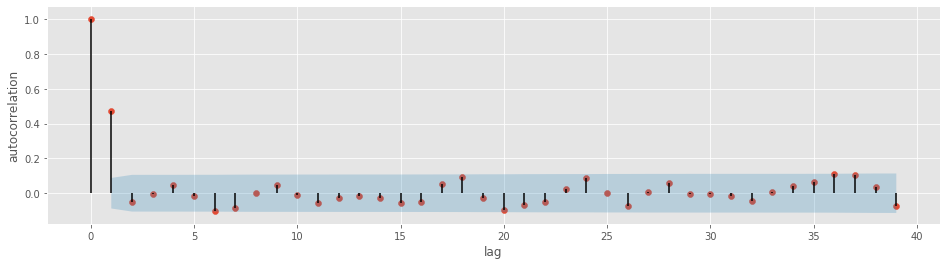

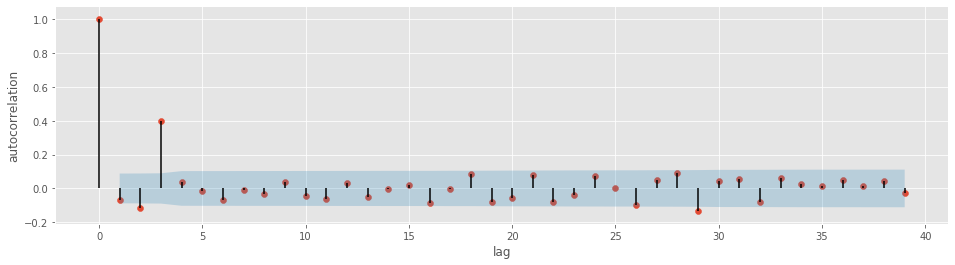

In [46]:
for array in [ma_1, ma_2]:
    plot_acf(array)

these plots help us infer the order of the MA(q) model. 

In both plots we can see a clear cut off in significant values. 

Both plots start with an autocorrelation of 1. 

This is the autocorrelation at lag 0. 

The second value is the autocorrelation at lag 1, the third at lag 2, etc. 

The first plot, the cut off is after 1 lag and in the second plot the cut off is at lag 3. 

So in our artificial data set we are able to determine the order of different MA(q) models by looking at the ACF plot!

### ACF (auto correlation function)

- the correlation between the observation at the current time spot and the obsrvations at previous time spots

## AR process

Now we are going to simulate another series called the Auto Regressive (RA) process. Again we’re going to infer the order of the process visually. This time we will be doing that with a __Partial AutoCorrelation Function (PACF).__

An AR(p) process is defined as:


$$ \Large X_t = c + \epsilon_t \sum_{i=1}^p{\phi_i X_{t-i}} $$


Now ϕ are the parameters of the process and p is the order of the process. 

Where MA(q) is a weighted average over the error terms (white noise), AR(p) is a weighted average over the previous values of the series $X_{t−p} $
. 

In [47]:
def ar_process(eps, phi):
    """
    Creates a AR process with a zero mean.
    """
    # Reverse the order of phi and add a 1 for current eps_t
    phi = np.r_[1, phi][::-1] 
    ar = eps.copy()
    offset = len(phi)
    for i in range(offset, ar.shape[0]):
        ar[i - 1] = ar[i - offset: i] @ phi
    return ar

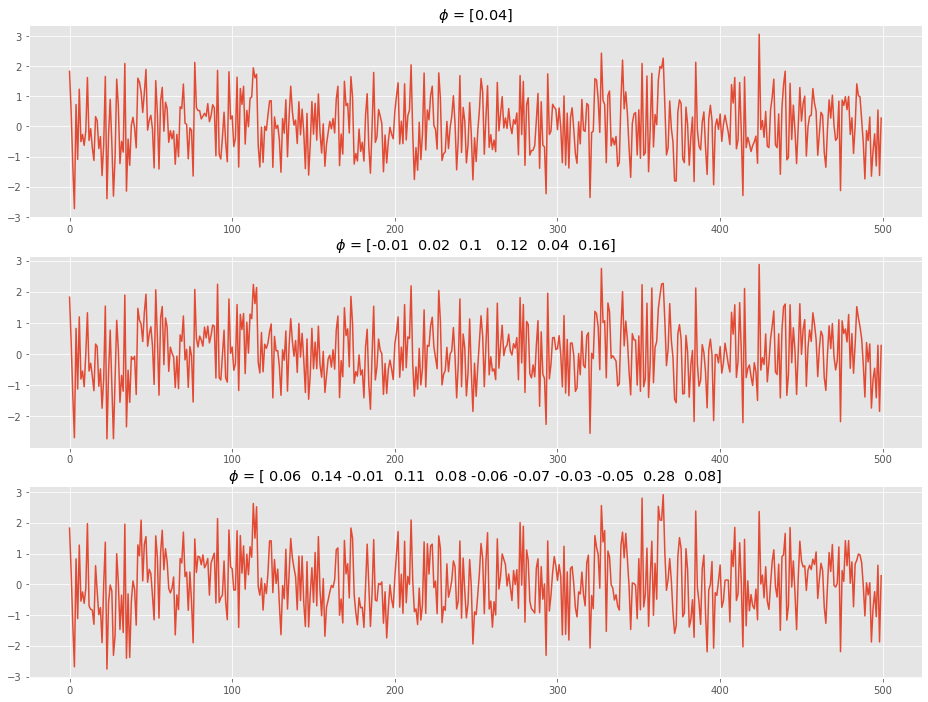

In [48]:
fig = plt.figure(figsize=(16, 4 * 3))
a = 310
for i in range(0, 11, 5):
    a += 1
    phi = np.random.normal(0, 0.1, size=i + 1)
    plt.subplot(a)
    plt.title(f'$\\phi$ = {phi.round(2)}')
    plt.plot(ar_process(eps, phi))

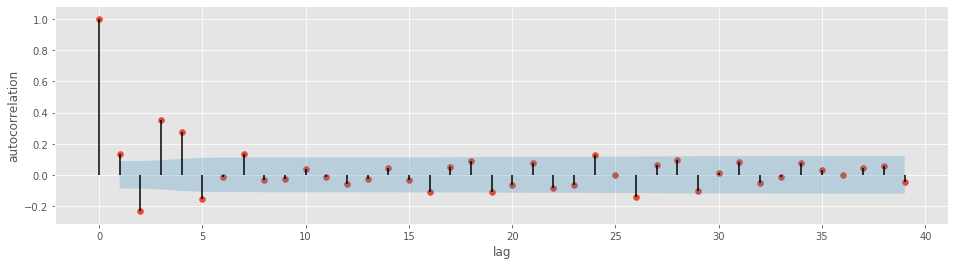

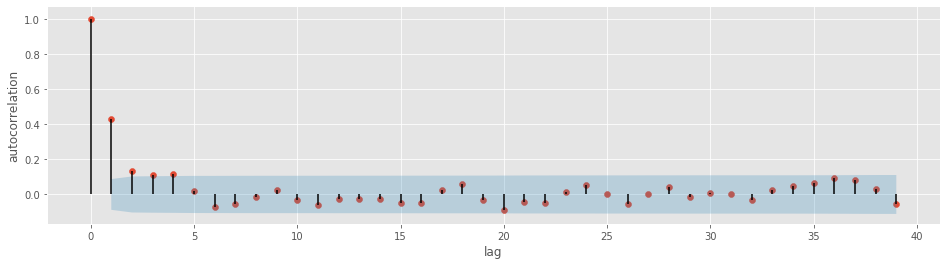

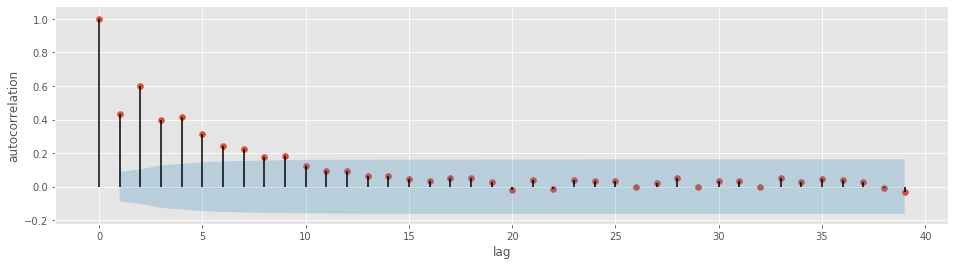

In [49]:
plot_acf(ar_process(eps, [0.3, -0.3, 0.5]))
plot_acf(ar_process(eps, [0.5, -0.1, 0.1]))
plot_acf(ar_process(eps, [0.2, 0.5, 0.1]))

By analyzing these plots we can tell that the ACF plot of these AR processes don’t necessarily cut off after lag 
p. 

In the first plot, we see that the ACF values tail off to zero, the second plot does have significant cut off at lag 
p and the third plot has a linearly decreasing autocorrelation until lag 14. 

For the AR(p) process, the ACF clearly isn’t decisive for determining the order of the process. Actually, for AR processes we can use another function for inferring the order of the process.

### Partial autocorrelation

The partial autocorrelation function shows the autocorrelation of value $X_t$ and $X_{t−k} $ after the correlation between 
$X_{t}$  with the intermediate values $X_{t−1}$ … $X_{t−k+1} $ explained. 

Below we’ll go through the steps required to determine partial autocorrelation.

The partial correlation between $X_t$ and $X_{t-k}$ can be determined by training two linear models.

Let $\hat{X_t}$ and $\hat{X_{t-k}}$ be determined by a Linear Model optimized on $X_{t-1} … X_{t-(k-1)}$ and parameterized by α and β

$$ \hat{X_t} = \alpha_1 X_{t-1} + \alpha_2 X_{t-2} … \alpha_{k-1} X_{t-(k-1)} $$

$$ \hat{X_{t-k}} = \beta_1 X_{t-1} + \beta_2 X_{t-2} … \beta_{k-1} X_{t-(k-1)} $$


he partial correlation is then defined by the Pearson’s coefficient of the residuals of both predicted values $\hat{X_t}$  and $\hat{X_{t-k}}$

$$ \Large PCAF(X_t, X_{t-k}) = corr((X_t - \hat{X_t}), (X_{t-k} - \hat{X_{t-k}})) $$

### Linear model

Linear regression is defined by: $ y = \beta X + \epsilon $

Where the parameters can be found by ordinary least squares:

$$ \beta = (X^TX)^{-1}X^Ty $$

### PACF 
Partial auto correlation function

In [50]:
def least_squares(x, y):
    return np.linalg.inv((x.T @ x)) @ (x.T @ y)

class LinearModel:
    def __init__(self, fit_intercept=True):
        self.fit_intercept = fit_intercept
        self.beta = None
        self.intercept_ = None
        self.coef_ = None
    
    def _prepare_features(self, x):
        if self.fit_intercept:
            x = np.hstack((np.ones((x.shape[0], 1)), x))
        return x
    
    def fit(self, x, y):
        x = self._prepare_features(x)
        self.beta = least_squares(x, y)
        if self.fit_intercept:
            self.intercept_ = self.beta[0]
            self.coef_ = self.beta[1:]
        else:
            self.coef_ = self.beta
        
    def predict(self, x):
        x = self._prepare_features(x)
        return x @ self.beta
    
    def fit_predict(self, x, y):
        self.fit(x, y)
        return self.predict(x)

In [51]:
def pacf(x, lag=40):
    """
    Partial autocorrelation function.
    
    pacf results in:
        [1, acf_lag_1, pacf_lag_2, pacf_lag_3]
    :param x: (array)
    :param lag: (int)
    """
    y = []
    
    # Partial auto correlation needs intermediate terms.
    # Therefore we start at index 3
    for i in range(3, lag + 2):
        backshifted = lag_view(x, i)[0]

        xt = backshifted[:, 0]
        feat = backshifted[:, 1:-1]
        xt_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt)

        xt_k = backshifted[:, -1]
        xt_k_hat = LinearModel(fit_intercept=False).fit_predict(feat, xt_k)

        y.append(pearson_correlation(xt - xt_hat, xt_k - xt_k_hat))
    return np.array([1, acf(x, 2)[1]] +  y)


In [53]:
def plot_pacf(x, alpha=0.05, lag=40, title=None):
    """
    :param x: (array)
    :param alpha: (flt) Statistical significance for confidence interval.
    :parm lag: (int)
    """
    pacf_val = pacf(x, lag)
    plt.figure(figsize=(16, 4))
    plt.vlines(np.arange(lag + 1), 0, pacf_val)
    plt.scatter(np.arange(lag + 1), pacf_val, marker='o')
    plt.xlabel('lag')
    plt.ylabel('autocorrelation')
    
    # Determine confidence interval
    ci = stats.norm.ppf(1 - alpha / 2.) * bartletts_formula(pacf_val, len(x))
    plt.fill_between(np.arange(1, ci.shape[0] + 1), -ci, ci, alpha=0.25)

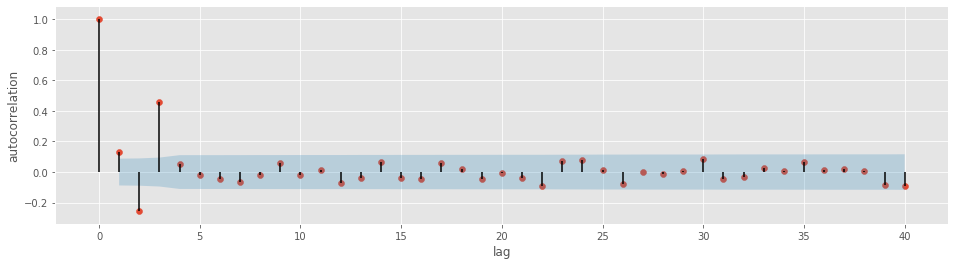

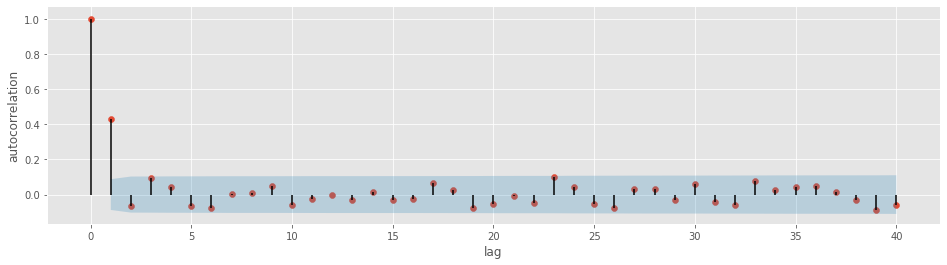

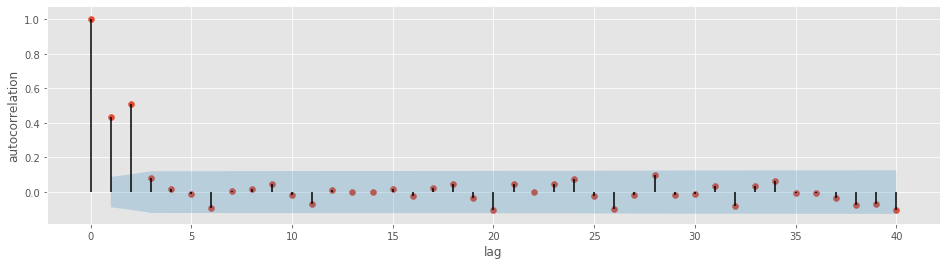

In [54]:
plot_pacf(ar_process(eps, [0.3, -0.3, 0.5]))
plot_pacf(ar_process(eps, [0.5, -0.1, 0.1]))
plot_pacf(ar_process(eps, [0.2,  0.5, 0.1]))

### The PACF for 3 AR processes.
Now we see a significant cut off at lag 3 for all 3 processes! We thus are able to infer the order of the processes. 

The relationship between AR and MA processes and the ACF and PACF plots are one to keep in mind, as they help with inferring the order of a certain series.


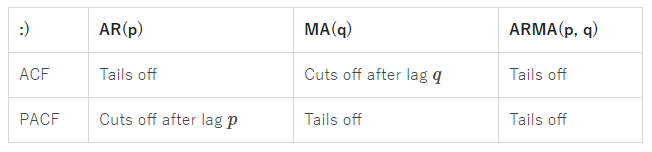

## Stationary

An ARMA model requires the data to be stationary, which an ARIMA model does not. 

A stationary series has a constant mean and a constant variance over time. 

- For the white noise, AR and MA processes we’ve defined above, this requirement holds, but for a lot of real-world data this does not. 

- ARIMA models can work with data that isn’t stationary, but instead has got a trend. 

- For time series that also have recurring patterns (seasonality), ARIMA models don’t work.

When the data shows a trend, we can remove the trend by __differencing__ time step $X_t$ with $X_{t-1}$

We can difference __n__ times until the data is stationary. 

We can test stationarity with a Dicker Fuller test. 

We can difference a time series by

$$ \Large \nabla X_t = X_t - X_{t-1} $$

and simply undo this by taking the sum

$$ \Large X_t = \nabla X_t + \nabla X_{t-1} $$

In [55]:
def difference(x, d=1):
    if d == 0:
        return x
    else:
        x = np.r_[x[0], np.diff(x)]
        return difference(x, d - 1)
    
def undo_difference(x, d=1):
    if d == 1:
        return np.cumsum(x)
    else:
        x = np.cumsum(x)
        return undo_difference(x, d - 1)

## ARIMA

Such a model has hyperparameters p, q and, d.

    p is the order of the AR model
    q is the order of the MA model
    d is the differencing order (how often we difference the data)
    
The ARMA and ARIMA combination is defined as

$$ X_t = c + \epsilon_t + \sum_{i=1}^{p}{\phi_i X_{t - i}} + \sum_{i = 1}^q{\theta_i \epsilon_{t-i}} $$

In [56]:
class ARIMA(LinearModel):
    def __init__(self, q, d, p):
        """
        An ARIMA model.
        :param q: (int) Order of the MA model.
        :param p: (int) Order of the AR model.
        :param d: (int) Number of times the data needs to be differenced.
        """
        super().__init__(True)
        self.p = p
        self.d = d
        self.q = q
        self.ar = None
        self.resid = None
        
    def prepare_features(self, x):
        if self.d > 0:
            x = difference(x, self.d)
                    
        ar_features = None
        ma_features = None
        
        # Determine the features and the epsilon terms for the MA process
        if self.q > 0:
            if self.ar is None:
                self.ar = ARIMA(0, 0, self.p)
                self.ar.fit_predict(x)
            eps = self.ar.resid
            eps[0] = 0
            
            # prepend with zeros as there are no residuals_t-k in the first X_t
            ma_features, _ = lag_view(np.r_[np.zeros(self.q), eps], self.q)
            
        # Determine the features for the AR process
        if self.p > 0:
            # prepend with zeros as there are no X_t-k in the first X_t
            ar_features = lag_view(np.r_[np.zeros(self.p), x], self.p)[0]
                                
        if ar_features is not None and ma_features is not None:
            n = min(len(ar_features), len(ma_features)) 
            ar_features = ar_features[:n]
            ma_features = ma_features[:n]
            features = np.hstack((ar_features, ma_features))
        elif ma_features is not None: 
            n = len(ma_features)
            features = ma_features[:n]
        else:
            n = len(ar_features)
            features = ar_features[:n]
        
        return features, x[:n]
    
    def fit(self, x):
        features, x = self.prepare_features(x)
        super().fit(features, x)
        return features
            
    def fit_predict(self, x): 
        """
        Fit and transform input
        :param x: (array) with time series.
        """
        features = self.fit(x)
        return self.predict(x, prepared=(features))
    
    def predict(self, x, **kwargs):
        """
        :param x: (array)
        :kwargs:
            prepared: (tpl) containing the features, eps and x
        """
        features = kwargs.get('prepared', None)
        if features is None:
            features, x = self.prepare_features(x)
        
        y = super().predict(features)
        self.resid = x - y

        return self.return_output(y)
    
    def return_output(self, x):
        if self.d > 0:
            x = undo_difference(x, self.d) 
        return x
    
    def forecast(self, x, n):
        """
        Forecast the time series.
        
        :param x: (array) Current time steps.
        :param n: (int) Number of time steps in the future.
        """
        features, x = self.prepare_features(x)
        y = super().predict(features)
        
        # Append n time steps as zeros. Because the epsilon terms are unknown
        y = np.r_[y, np.zeros(n)]
        for i in range(n):
            feat = np.r_[y[-(self.p + n) + i: -n + i], np.zeros(self.q)]
            y[x.shape[0] + i] = super().predict(feat[None, :])
        return self.return_output(y)

- ARIMA class inherits from LinearModel so first we initiate the parent and we pass the boolean True so that we also fit an intercept for the model.

- In the prepare_features method, (note that this one has no _ prefix and thus differs from the parent method) we create the features for the linear regression model. The features comprise of the lagging time steps $X_{t-k}$ with order q, which is the AR part of the model,  and of the lagging error terms $\epsilon_{t-k}$ , which is the MA part of the model.

Let’s first check how an object of the class is doing by comparing it with statsmodels implementation. We will also use test data coming from this library.

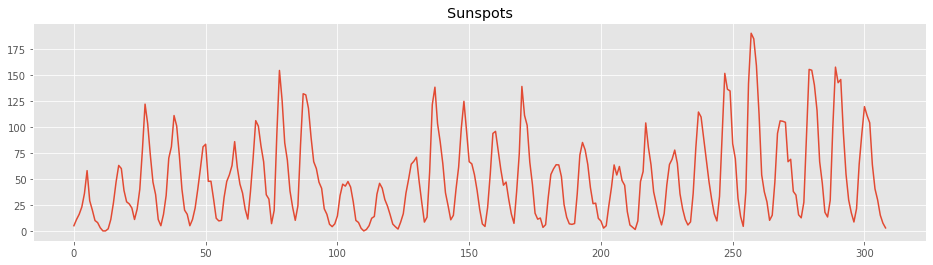

In [63]:
data = sm.datasets.sunspots.load_pandas().data
x = data['SUNACTIVITY'].values.squeeze()

plt.figure(figsize=(16,4))
plt.title('Sunspots')
plt.plot(x)

By the look of this data, it seems stationary. 

The mean and the variance don’t seem to be changing over time, so we can infer the first hyperparameter for this model. We don’t need to difference so d is set to 0. 

Let’s make an ACF and a PACF plot.

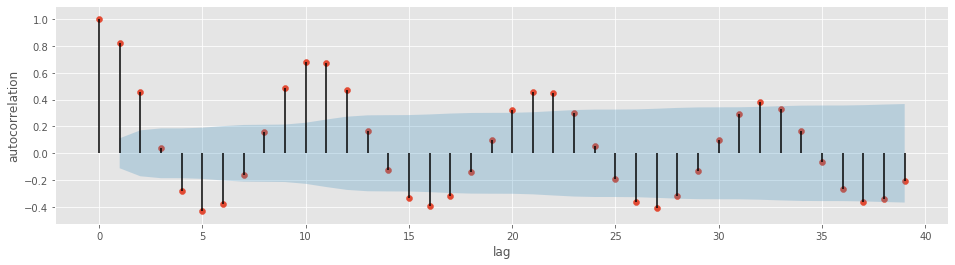

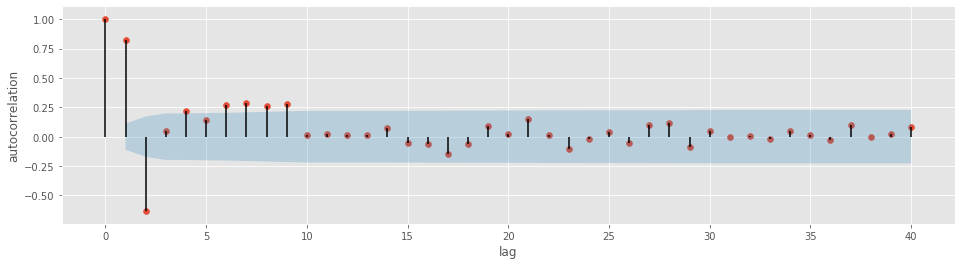

In [64]:
plot_acf(x)
plot_pacf(x)